In [41]:
# imports
import numpy as np
import pandas as pd
import json

# modelling
from sklearn import datasets
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, classification_report, auc, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import randint

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset split: 56000 train rows 56000 label rows
Dataset split: 14000 test rows 14000 label rows


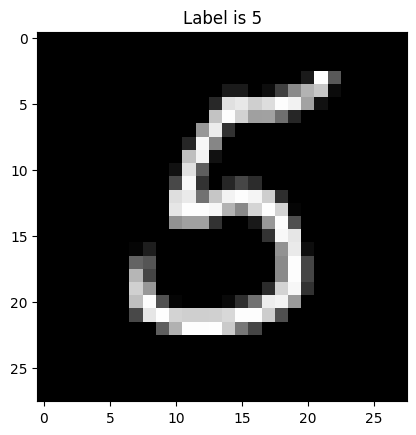

In [3]:
# Initialize
mnist = datasets.fetch_openml("mnist_784")
X, y = mnist.data, mnist.target

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# digits = load_digits()
print(f"Dataset split: {len(x_train)} train rows",
          f"{len(y_train)} label rows")

print(f"Dataset split: {len(x_test)} test rows",
          f"{len(y_test)} label rows")

point = np.array(x_train.iloc[0], dtype='uint8')
point = point.reshape((28, 28))

plt.title('Label is {label}'.format(label=y_train.iloc[0]))
plt.imshow(point, cmap='gray')
plt.show()

In [4]:
print(x_train.shape)
print(x_test.shape)

(56000, 784)
(14000, 784)


In [5]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

# convert labels to integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [5]:
# TODO: Find out if I want to do like this for the MNIST data
best_score = float('-inf')
best_params = None

# Manual parameter search
for n_neighbors in [5, 10, 15, 20]:
    for contamination in [0.05, 0.1, 0.15, 0.2]:
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        lof.fit(x_train)

        # Use the negative_outlier_factor_ attribute for evaluation
        scores = -lof.negative_outlier_factor_

        # Compute a simple score (you can use a different metric if needed)
        score = sum(scores)

        # Update best parameters if the score is better
        if score > best_score:
            best_score = score
            best_params = {'n_neighbors': n_neighbors, 'contamination': contamination}

print("Best Parameters:", best_params)
# TODO: Ends here

In [6]:
# Create and fit a Local Outlier Factor model
model = LocalOutlierFactor(n_neighbors=5, contamination=0.05)
model.fit(x_train)

LocalOutlierFactor(contamination=0.05, n_neighbors=5)

In [7]:
y_pred = model.fit_predict(x_test)

# Calculate anomaly scores
anomaly_scores = -model.negative_outlier_factor_

In [8]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [10]:
# Get the indices of anomalies in the test set
anomaly_indexes = np.where(y_pred == -1)[0]

# Display the anomaly indices
print("Anomaly Indexes:", anomaly_indexes)
print(len(anomaly_indexes))

Anomaly Indexes: [   17    18    47    86   112   123   151   180   216   240   241   244
   267   270   352   353   393   466   488   523   556   562   565   566
   589   590   599   605   649   651   671   672   674   686   736   750
   755   756   758   777   788   809   827   828   830   905   910   922
   940   971  1029  1047  1062  1091  1106  1111  1115  1148  1194  1203
  1214  1230  1233  1264  1401  1418  1438  1480  1495  1498  1597  1650
  1706  1707  1711  1741  1757  1765  1795  1861  1873  1882  1883  1903
  1916  1917  1922  1924  1965  1987  1999  2044  2096  2116  2124  2139
  2160  2169  2191  2201  2234  2254  2297  2327  2338  2391  2407  2413
  2419  2431  2467  2481  2510  2511  2513  2515  2523  2547  2607  2617
  2718  2726  2727  2738  2759  2765  2782  2789  2790  2792  2882  2934
  2944  2986  2993  3005  3008  3011  3021  3025  3055  3057  3059  3090
  3124  3135  3182  3234  3258  3286  3295  3312  3313  3318  3352  3384
  3391  3401  3403  3404  3503  35

In [12]:
# Convert the list of anomaly indexes to a NumPy array
anomaly_indexes_array = np.array(anomaly_indexes)

# Extract labels of anomalies
anomaly_labels = y_test.iloc[anomaly_indexes_array]

# Display the anomaly labels
print("Anomaly Labels:", anomaly_labels)

Anomaly Labels: 31386    1
63361    7
12000    7
22328    1
31284    7
        ..
33820    8
16033    2
25662    4
65759    1
12510    1
Name: class, Length: 700, dtype: int32


In [15]:
# Extract anomaly images from the test set
anomalies = x_test.iloc[anomaly_indexes_array]

print(len(anomalies))

700


In [16]:
# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), anomaly_labels))

In [17]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


In [18]:
# Reshape the test data for plotting
x_test_reshaped = x_test.values.reshape(-1, 28, 28)

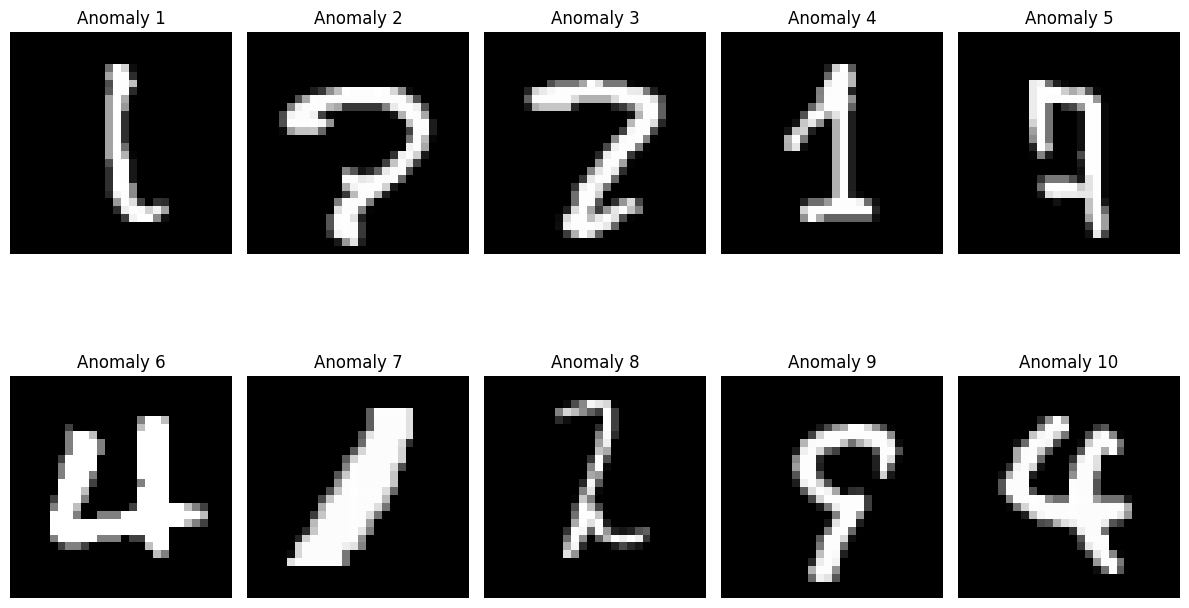

In [19]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomalies
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_reshaped[idx], cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


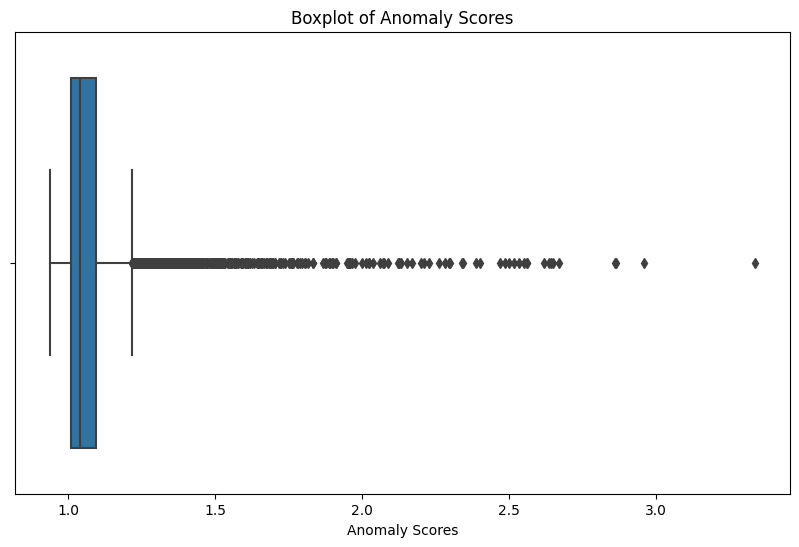

In [51]:
# Boxplot for all data
plt.figure(figsize=(10, 6))
sns.boxplot(x=anomaly_scores)
plt.title('Boxplot of Anomaly Scores')
plt.xlabel('Anomaly Scores')
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


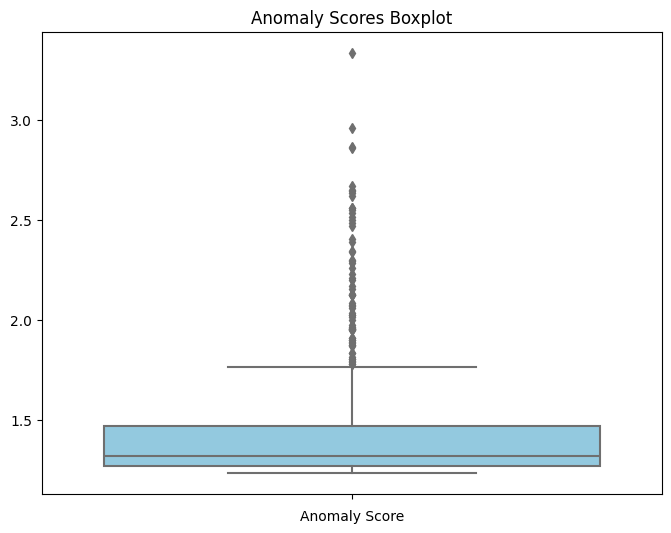

In [21]:
# Plot a boxplot for anomalies
plt.figure(figsize=(8, 6))
sns.boxplot(y=anomaly_scores[anomaly_indexes_array], color='skyblue')
plt.title('Anomaly Scores Boxplot')
plt.xlabel('Anomaly Score')
plt.show()

In [33]:
# Create ground truth labels for anomalies (1 if anomaly, 0 otherwise)
true_labels = np.zeros(len(y_test))
true_labels[anomaly_indexes_array] = 1

In [34]:
# Map the class labels to "anomaly" and "normal" for true labels
class_labels = {0: 'normal', 1: 'anomaly'}
true_labels_mapped = np.vectorize(class_labels.get)(true_labels)

In [35]:
# Ensure that true_labels_mapped and y_pred are binary (0 or 1)
true_labels_binary = np.where(true_labels_mapped == 'anomaly', 1, 0)

In [36]:
# Calculate metrics
accuracy = accuracy_score(true_labels_binary, y_pred == -1)
precision = precision_score(true_labels_binary, y_pred == -1)
recall = recall_score(true_labels_binary, y_pred == -1)
f1 = f1_score(true_labels_binary, y_pred == -1)

In [37]:
# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [38]:
# Classification report
report = classification_report(true_labels_binary, y_pred == -1, target_names=['normal', 'anomaly'])

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     13300
     anomaly       1.00      1.00      1.00       700

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000



In [49]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(true_labels_binary, -anomaly_scores)

# Calculate PR-AUC
pr_auc = auc(recall, precision)

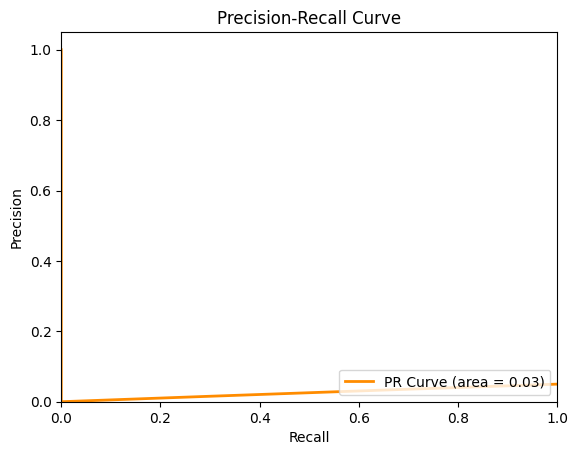

In [50]:
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [43]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels_binary, y_pred == -1)

In [44]:
print(conf_matrix)

[[13300     0]
 [    0   700]]


In [45]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 13300
False Positives: 0
False Negatives: 0
True Positives: 700
